Figure saved as density_convolution_results.png


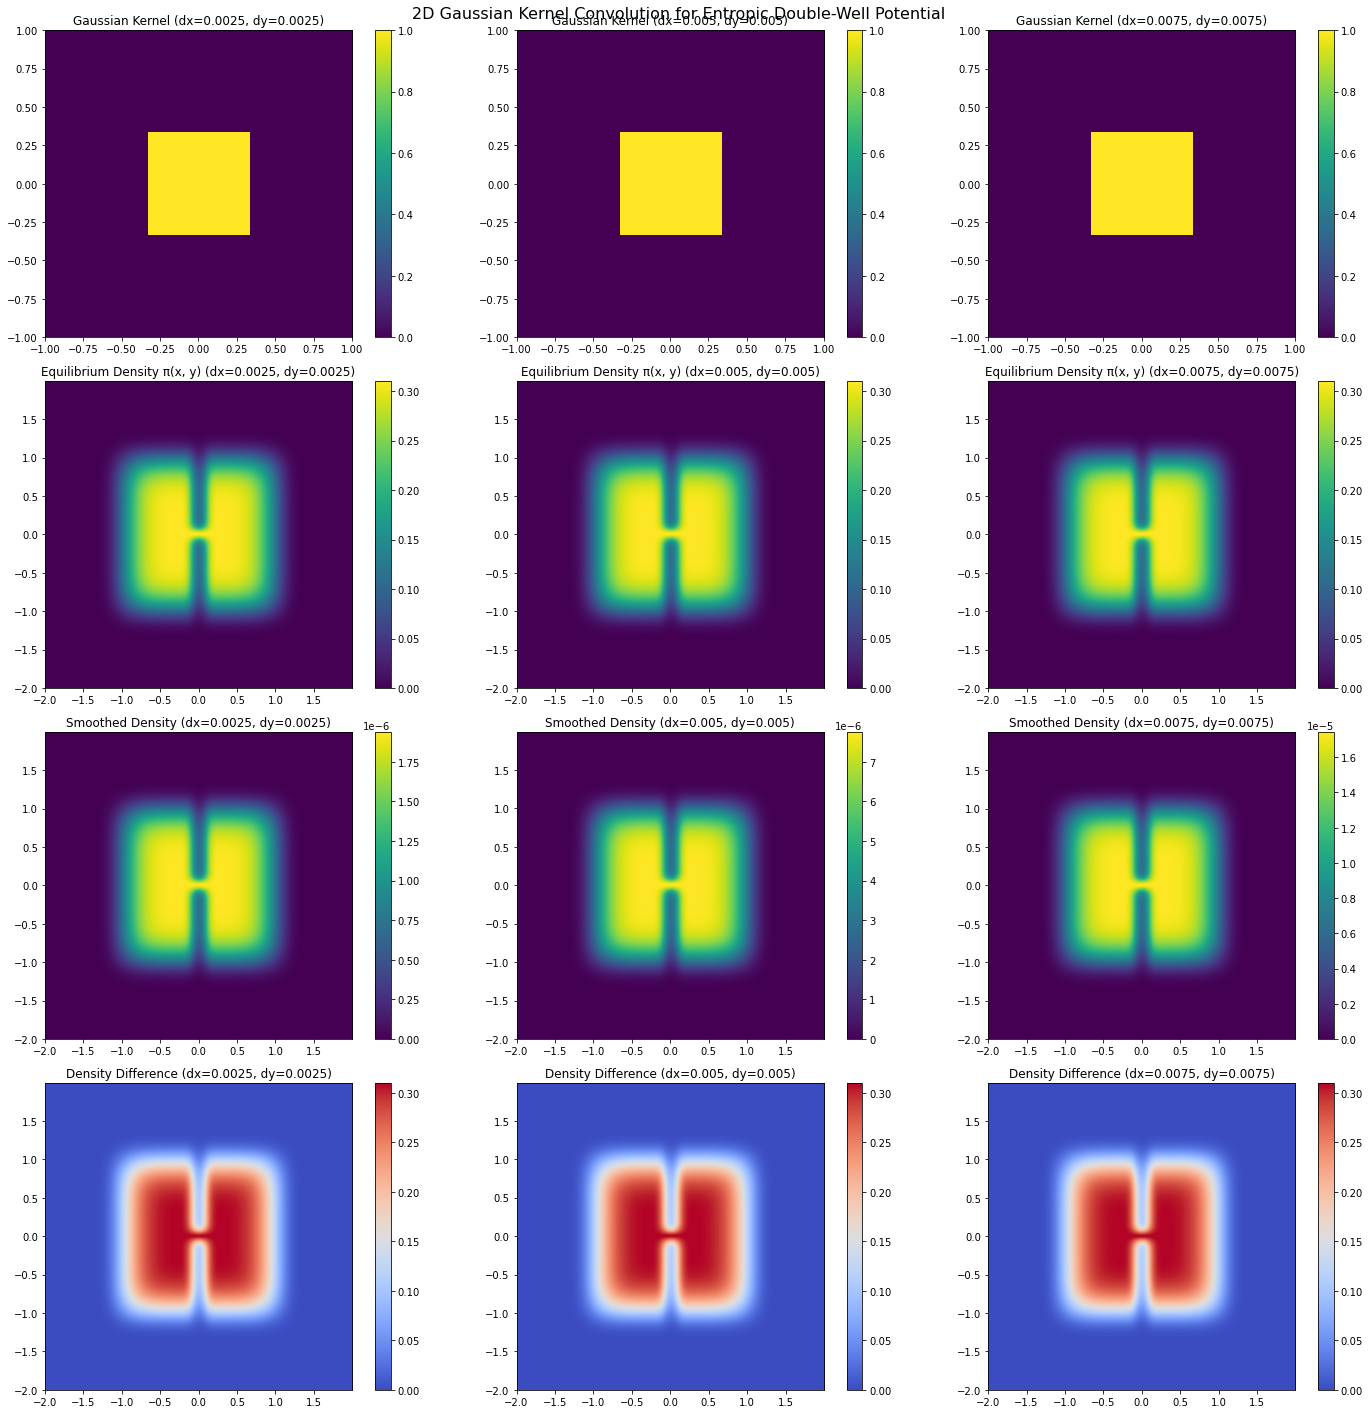

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 2D Entropic Double-Well Potential
def entropic_double_well(x, y, a, sigma_x, sigma_y):
    """
    Computes the 2D entropic double-well potential.

    Parameters:
    - x, y: The positions at which to evaluate the potential.
    - a: Amplitude of the potential.
    - sigma_x, sigma_y: The widths of the entropic barrier in x and y directions.

    Returns:
    - U(x, y): The potential value at position (x, y).
    """
    # Compute the potential with a cap to avoid overflow
    potential = a * (x**6 + y**6 + np.exp(-x**2 / sigma_x**2) * (1 - np.exp(-y**2 / sigma_y**2)))
    return np.minimum(potential, 100)  # Cap potential to prevent numerical overflow

# 2D Gaussian Kernel
def gaussian_kernel_2d(x, y, sigma_kernel_x, sigma_kernel_y):
    """
    2D Gaussian Kernel function.

    Parameters:
    - x, y: The positions at which to evaluate the kernel.
    - sigma_kernel_x, sigma_kernel_y: The bandwidths of the kernel in x and y directions.

    Returns:
    - Value of the Gaussian kernel at (x, y).
    """
    coeff = 1.0 / (2.0 * np.pi * sigma_kernel_x * sigma_kernel_y)
    exponent = -0.5 * ((x / sigma_kernel_x)**2 + (y / sigma_kernel_y)**2)
    kernel = coeff * np.exp(exponent)
    # Avoid division by zero by setting a minimum value
    kernel = np.where(kernel < 1e-300, 1e-300, kernel)
    return kernel

def convolve_density_2d(boltz_array, kernel_array, dx, dy):
    """Perform convolution on the 2D density array."""
    nx, ny = boltz_array.shape
    kernel_nx, kernel_ny = kernel_array.shape
    boltz_array_conv = np.zeros_like(boltz_array)

    kernel_half_x = (kernel_nx - 1) // 2
    kernel_half_y = (kernel_ny - 1) // 2

    for i in range(nx):
        for j in range(ny):
            for kx in range(kernel_nx):
                for ky in range(kernel_ny):
                    shift_x = i - kernel_half_x + kx
                    shift_y = j - kernel_half_y + ky
                    if 0 <= shift_x < nx and 0 <= shift_y < ny:
                        boltz_array_conv[shift_x, shift_y] += boltz_array[i, j] * kernel_array[kx, ky] * dx * dy

    return boltz_array_conv

def plot_results_2d(lattice_spacings, sigma_x, sigma_y, sigma_kernel_x, sigma_kernel_y, a, x_min, x_max, y_min, y_max, filename):
    fig, axs = plt.subplots(4, len(lattice_spacings), figsize=(20, 20))
    fig.patch.set_facecolor('white')  # Set the background color of the figure

    for i, (dx, dy) in enumerate(lattice_spacings):
        x = np.arange(x_min, x_max, dx)
        y = np.arange(y_min, y_max, dy)
        X, Y = np.meshgrid(x, y)

        # Potential array
        potential_array = entropic_double_well(X, Y, a, sigma_x, sigma_y)
        boltz_array = np.exp(-potential_array)

        # Avoid invalid values and normalize Boltzmann density
        boltz_array[np.isinf(boltz_array)] = 0
        integral = np.trapz(np.trapz(boltz_array, x), y)
        if integral > 1e-300:
            boltz_array /= integral

        # Kernel array
        kernel_size_x = max(1, int(5 * sigma_kernel_x))  # Ensure kernel size is at least 1
        kernel_size_y = max(1, int(5 * sigma_kernel_y))
        kernel_x = np.linspace(-kernel_size_x, kernel_size_x, 2 * kernel_size_x + 1)
        kernel_y = np.linspace(-kernel_size_y, kernel_size_y, 2 * kernel_size_y + 1)
        
        # Check if kernel_x and kernel_y have valid ranges
        if np.all(kernel_x == 0) or np.all(kernel_y == 0):
            raise ValueError("Kernel size is too small, leading to zero range in kernel_x or kernel_y.")

        Kernel_X, Kernel_Y = np.meshgrid(kernel_x, kernel_y)
        kernel_array = gaussian_kernel_2d(Kernel_X, Kernel_Y, sigma_kernel_x, sigma_kernel_y)

        # Normalize kernel
        kernel_integral = np.trapz(np.trapz(kernel_array, kernel_x), kernel_y)
        if kernel_integral > 1e-300:
            kernel_array /= kernel_integral

        # Convolve the density
        boltz_array_conv = convolve_density_2d(boltz_array, kernel_array, dx, dy)

        # Compute potential from convolved density
        with np.errstate(divide='ignore', invalid='ignore'):
            potential_array_conv = -np.log(boltz_array_conv)
            potential_array_conv[np.isinf(potential_array_conv)] = np.nan

        # Compute the difference between original and smoothed densities
        density_diff = boltz_array - boltz_array_conv
        density_diff[np.isnan(density_diff)] = 0

        # Plot the results
        im_kernel = axs[0, i].imshow(kernel_array, extent=(kernel_x.min(), kernel_x.max(), kernel_y.min(), kernel_y.max()), origin='lower')
        axs[0, i].set_title(f'Gaussian Kernel (dx={dx}, dy={dy})')
        axs[0, i].set_facecolor('white')  # Set background color of the axis
        plt.colorbar(im_kernel, ax=axs[0, i])

        im_density = axs[1, i].imshow(boltz_array, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower')
        axs[1, i].set_title(f'Equilibrium Density Ï€(x, y) (dx={dx}, dy={dy})')
        axs[1, i].set_facecolor('white')  # Set background color of the axis
        plt.colorbar(im_density, ax=axs[1, i])

        im_smoothed = axs[2, i].imshow(boltz_array_conv, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower')
        axs[2, i].set_title(f'Smoothed Density (dx={dx}, dy={dy})')
        axs[2, i].set_facecolor('white')  # Set background color of the axis
        plt.colorbar(im_smoothed, ax=axs[2, i])

        im_diff = axs[3, i].imshow(density_diff, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='coolwarm')
        axs[3, i].set_title(f'Density Difference (dx={dx}, dy={dy})')
        axs[3, i].set_facecolor('white')  # Set background color of the axis
        plt.colorbar(im_diff, ax=axs[3, i])

    fig.suptitle('2D Gaussian Kernel Convolution for Entropic Double-Well Potential', fontsize=16)
    plt.tight_layout()

    # Save the figure
    plt.savefig(filename, bbox_inches='tight', facecolor='white')
    print(f"Figure saved as {filename}")

if __name__ == "__main__":
    lattice_spacings = [(0.0025, 0.0025), (0.005, 0.005), (0.0075, 0.0075)]  # Finer lattice spacings
    sigma_x, sigma_y = 0.1, 0.1  # Widths of the entropic barrier
    sigma_kernel_x, sigma_kernel_y = 0.1, 0.1  # Bandwidths for the Gaussian kernel
    a = 1  # Amplitude of the potential
    x_min, x_max = -2, 2  # x range
    y_min, y_max = -2, 2  # y range
    filename = 'density_convolution_results.png'  # Filename to save the plot
    plot_results_2d(lattice_spacings, sigma_x, sigma_y, sigma_kernel_x, sigma_kernel_y, a, x_min, x_max, y_min, y_max, filename)
